In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler

all_markers = list(Line2D.markers.keys())

# Analyzing NOSC of the E. coli proteome
We need in order to compare between experiments from different we need absolute quantification of proteins per unit volume. Recent datasets of this quality were collected for by Griffin Chure and Nathan Bellivue Cell Systems 2021. 

# Differences between lab practices
Valgepea 2013 uses data collected in Valgepea 2010, where E. coli was cultured in a custom minimal medium documented in Nahku et al. 2010. Peebo et al. 2015 is from the same group (Vilu) and appears to use the same growth medium base with some amino acid supplementation. 

Minimal media used by Schmidt et al. 2015 uses an M9 base that is distinct from the medium in the Vilu group. 

# Known issues
* I am using the MG1655 proteome for all samples, but Schmidt et al. and Peebo et al. are working with BW25113. There may be minor differences in protein sequence. 

# Additional E. coli data sources
* Hui et al. MSB 2015 is from Hwa & Williamson groups
* Maser et al. 2021 from Vilu and Nahku groups
* 

In [2]:
conds_df = pd.read_csv('../data/growth_conditions.csv', index_col=0)
raw_abund_df = pd.read_csv('../data/Chure_compiled_absolute_measurements.csv', index_col=0).reset_index().set_index('b_number')
nosc_df = pd.read_csv('../data/MG1655_proteome_nosc.csv', index_col=0)

In [3]:
raw_abund_df

,gene_name,condition,go_terms,cog_class,cog_category,cog_letter,growth_rate_hr,gene_product,tot_per_cell,fg_per_cell,dataset,dataset_name,strain
b_number,,,,,,,,,,,,,
b0259,InsH-1,lb_miller,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.90,CP4-6 prophage; IS5 transposase and trans-acti...,263.834345,0.017224,schmidt_2016,Schmidt et al. 2016,BW25113
b0259,InsH-1,glycerol_pAA,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.27,CP4-6 prophage; IS5 transposase and trans-acti...,123.587772,0.008068,schmidt_2016,Schmidt et al. 2016,BW25113
b0259,InsH-1,acetate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.30,CP4-6 prophage; IS5 transposase and trans-acti...,18.492529,0.001207,schmidt_2016,Schmidt et al. 2016,BW25113
b0259,InsH-1,fumarate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.42,CP4-6 prophage; IS5 transposase and trans-acti...,58.741236,0.003835,schmidt_2016,Schmidt et al. 2016,BW25113
b0259,InsH-1,galactose,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.26,CP4-6 prophage; IS5 transposase and trans-acti...,39.742334,0.002594,schmidt_2016,Schmidt et al. 2016,BW25113
...,...,...,...,...,...,...,...,...,...,...,...,...,...
b1852,zwf,rich,GO:0016614; GO:0005515; GO:0042802; GO:0010699...,metabolism,carbohydrate transport and metabolism,G,0.65,GLU6PDEHYDROG-MONOMER,1074.805447,0.099386,peebo_2015,Peebo et al. 2015,BW25113
b1852,zwf,rich,GO:0016614; GO:0005515; GO:0042802; GO:0010699...,metabolism,carbohydrate transport and metabolism,G,0.73,GLU6PDEHYDROG-MONOMER,1079.410764,0.099812,peebo_2015,Peebo et al. 2015,BW25113
b1852,zwf,rich,GO:0016614; GO:0005515; GO:0042802; GO:0010699...,metabolism,carbohydrate transport and metabolism,G,0.74,GLU6PDEHYDROG-MONOMER,1197.355432,0.110718,peebo_2015,Peebo et al. 2015,BW25113


In [4]:
# Take the mean of replicates for the same gene.
# NB: Assuming same dataset, strain, cond, gene and growth rate implies replicate. 
counts = raw_abund_df.reset_index().groupby('dataset,strain,condition,b_number,growth_rate_hr'.split(',')).mean()
abund_df = counts.reset_index().set_index('b_number')

# Keep only the b-numbers that we have abundance and NOSC data for.
overlapping_idx = set(nosc_df.index.values).intersection(abund_df.index.values)
abund_df = abund_df.loc[overlapping_idx].copy()
nosc_df = nosc_df.loc[overlapping_idx].copy()

# Add NOSC and NC data to the abundance dataframe
abund_df['NOSC'] = nosc_df.loc[abund_df.index].NOSC
abund_df['NC'] = nosc_df.loc[abund_df.index].NC
abund_df['MW'] = nosc_df.loc[abund_df.index].MW
abund_df['naa'] = nosc_df.loc[abund_df.index].naa

# Formal Carbon-bound e- per protein copy
abund_df['Ce_per'] = nosc_df.loc[abund_df.index].Ce_tot
# Total Carbon-bound e-/cell on this protein, i.e. weighted by copies/cell 
abund_df['Ce_total'] = abund_df.Ce_per * abund_df.tot_per_cell
# Total Carbon atoms on this protein, i.e. weighted by copies/cell 
abund_df['NC_total'] = abund_df.NC * abund_df.tot_per_cell
abund_df.to_csv('../data/Chure_mean_absolute_measurements.csv')
abund_df.head()


,dataset,strain,condition,growth_rate_hr,tot_per_cell,fg_per_cell,NOSC,NC,MW,naa,Ce_per,Ce_total,NC_total
b_number,,,,,,,,,,,,,
b3235,li_2014,MG1655,MOPS complete,1.934364,446.799517,0.027873,-0.163033,1655,37580.5493,355,-269.82,-120555.445780,739453.201266
b3235,li_2014,MG1655,MOPS complete without methionine,1.569390,176.100066,0.010986,-0.163033,1655,37580.5493,355,-269.82,-47515.319885,291445.609700
b3235,li_2014,MG1655,MOPS minimal,0.738700,151.809293,0.009471,-0.163033,1655,37580.5493,355,-269.82,-40961.183334,251244.379279
b3235,peebo_2015,BW25113,glucose_minimal,0.210000,NaN,NaN,-0.163033,1655,37580.5493,355,-269.82,NaN,NaN
b3235,peebo_2015,BW25113,glucose_minimal,0.220000,NaN,NaN,-0.163033,1655,37580.5493,355,-269.82,NaN,NaN


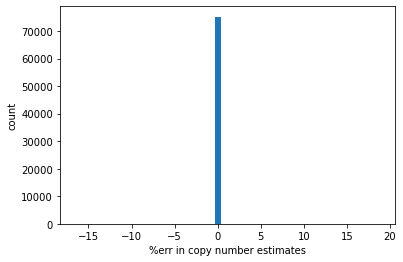

In [5]:
# Check that our MW values are consistent with Griffin's. Looks good.
estimated_copies = abund_df.fg_per_cell*1e-15*6.02e23 / abund_df.MW
rel_err = (estimated_copies - abund_df.tot_per_cell) / abund_df.tot_per_cell
plt.hist(100*rel_err, bins=50)
plt.xlabel('%err in copy number estimates')
plt.ylabel('count')
plt.show()

In [6]:
proteome_nosc_df = abund_df.groupby('dataset,strain,condition,growth_rate_hr'.split(',')).sum()
proteome_nosc_df = proteome_nosc_df[['Ce_total', 'NC_total']].copy() 
proteome_nosc_df['NOSC'] = proteome_nosc_df.Ce_total / proteome_nosc_df.NC_total
proteome_nosc_df = proteome_nosc_df.reset_index()
proteome_nosc_df

,dataset,strain,condition,growth_rate_hr,Ce_total,NC_total,NOSC
0,li_2014,MG1655,MOPS complete,1.934364,-2.874830e+09,1.978964e+10,-0.145269
1,li_2014,MG1655,MOPS complete without methionine,1.569390,-2.086441e+09,1.455779e+10,-0.143321
2,li_2014,MG1655,MOPS minimal,0.738700,-1.020921e+09,7.198239e+09,-0.141829
3,peebo_2015,BW25113,glucose_minimal,0.210000,-6.325407e+08,4.438576e+09,-0.142510
4,peebo_2015,BW25113,glucose_minimal,0.220000,-6.375270e+08,4.478724e+09,-0.142346
5,peebo_2015,BW25113,glucose_minimal,0.260000,-6.635508e+08,4.644040e+09,-0.142882
6,peebo_2015,BW25113,glucose_minimal,0.310000,-6.982085e+08,4.861950e+09,-0.143607
7,peebo_2015,BW25113,glucose_minimal,0.360000,-7.350155e+08,5.083519e+09,-0.144588
8,peebo_2015,BW25113,glucose_minimal,0.410000,-7.672300e+08,5.320595e+09,-0.144200
9,peebo_2015,BW25113,glucose_minimal,0.460000,-8.053357e+08,5.565668e+09,-0.144697


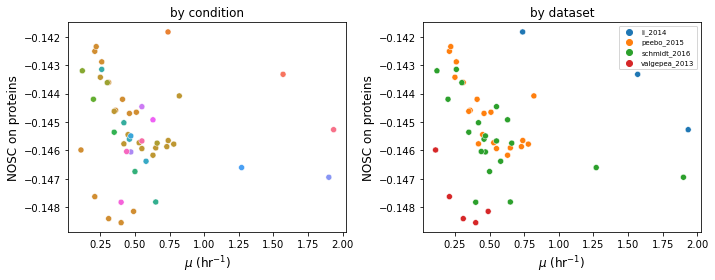

In [7]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)

for ax, hue in zip(axs, ['condition', 'dataset']):
    plt.sca(ax)
    sns.scatterplot(data=proteome_nosc_df, x='growth_rate_hr', y='NOSC', hue=hue, legend=True)
    plt.legend().set_visible(False)
    plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=12)
    plt.ylabel('NOSC on proteins', fontsize=12)
    plt.title('by {0}'.format(hue))

plt.legend(fontsize=7)

plt.tight_layout()
plt.savefig('../output/protein_NOSC_Chure_data.png', facecolor='w', dpi=600)
plt.show()

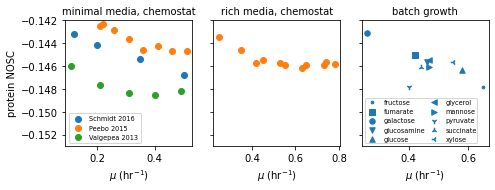

In [8]:
fig, axs = plt.subplots(figsize=(7,2.75), ncols=3, sharey=True)
pal = sns.color_palette()
schmidt_color = pal[0]
peebo_color = pal[1]
valgepea_color = pal[2]

plt.sca(axs[0])
mask = np.logical_and(proteome_nosc_df.dataset == 'schmidt_2016',
                      proteome_nosc_df.condition.str.startswith('chemo'))
sub_df = proteome_nosc_df[mask]
plt.scatter(sub_df.growth_rate_hr, sub_df.NOSC,
            label='Schmidt 2016', color=schmidt_color)

mask = np.logical_and(proteome_nosc_df.dataset == 'peebo_2015',
                      proteome_nosc_df.condition.str.startswith('glucose_minimal'))
sub_df = proteome_nosc_df[mask]
plt.scatter(sub_df.growth_rate_hr, sub_df.NOSC,
            label='Peebo 2015', color=peebo_color)

mask = np.logical_and(proteome_nosc_df.dataset == 'valgepea_2013',
                      proteome_nosc_df.condition.str.startswith('glucose_minimal'))
sub_df = proteome_nosc_df[mask]
plt.scatter(sub_df.growth_rate_hr, sub_df.NOSC,
            label='Valgepea 2013', color=valgepea_color)

plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=10)
plt.ylabel('protein NOSC', fontsize=10)
plt.title('minimal media, chemostat', fontsize=10)

plt.legend(fontsize=6.5, loc=3)

plt.sca(axs[1])
mask = np.logical_and(proteome_nosc_df.dataset == 'peebo_2015',
                      proteome_nosc_df.condition.str.startswith('rich'))
mask = np.logical_and(mask, proteome_nosc_df.growth_rate_hr < 0.8)
sub_df = proteome_nosc_df[mask]
plt.scatter(sub_df.growth_rate_hr, sub_df.NOSC,
            label='Peebo 2015', color=peebo_color)

plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=10)
plt.title('rich media, chemostat', fontsize=10)

plt.sca(axs[2])
conds = 'glucose,fructose,galactose,glucosamine,xylose,mannose,glycerol,succinate,fumarate,pyruvate'.split(',')
mask = np.logical_and(proteome_nosc_df.dataset == 'schmidt_2016',
                      proteome_nosc_df.condition.isin(conds))
sub_df = proteome_nosc_df[mask]
for i, (idx, row) in enumerate(sub_df.iterrows()):
    plt.scatter(row.growth_rate_hr, row.NOSC, label=row.condition,
                s=30, marker=all_markers[i], color=schmidt_color)

plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=10)
plt.title('batch growth', fontsize=10)

plt.ylim(-0.153, -0.142)
plt.legend(fontsize=6.5, loc=3, ncols=2, borderpad=0.1, columnspacing=0.3)

plt.tight_layout()
plt.savefig('../output/EC_proteomics_NOSC.png', facecolor='w', dpi=600)
plt.show()

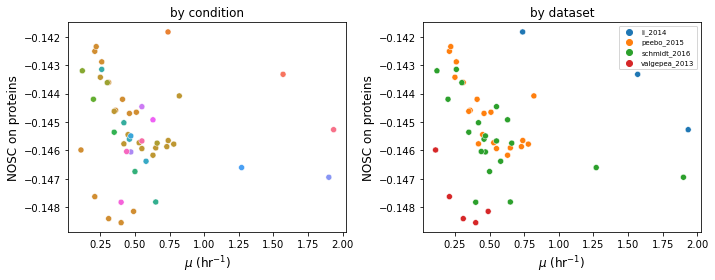

In [9]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)

for ax, hue in zip(axs, ['condition', 'dataset']):
    plt.sca(ax)
    sns.scatterplot(data=proteome_nosc_df, x='growth_rate_hr', y='NOSC', hue=hue, legend=True)
    plt.legend().set_visible(False)
    plt.xlabel('$\mu$ (hr$^{-1}$)', fontsize=12)
    plt.ylabel('NOSC on proteins', fontsize=12)
    plt.title('by {0}'.format(hue))

plt.legend(fontsize=7)

plt.tight_layout()
plt.savefig('../output/protein_NOSC_Chure_data.png', facecolor='w', dpi=600)
plt.show()

In [10]:
my_abund_df = abund_df.copy()
my_abund_df['x'] = -my_abund_df.Ce_total
my_abund_df['log10_x'] = np.log10(-my_abund_df.Ce_total)

sorted_abund = my_abund_df.sort_values('log10_x', ascending=False)
group_cols = 'dataset,strain,condition,growth_rate_hr'.split(',')
for gid, gdf in sorted_abund.groupby(group_cols):
    pass
    #display(gdf.head(10))

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
def _linear_mean(log_vals): 
    return np.log10(
        np.power(10, log_vals).mean())

def _linear_std(log_vals): 
    return np.log10(
        np.power(10, log_vals).std())
    
def _plot_mean(x, color, label):
    ax = plt.gca()
    vals = x[x.notnull()]
    vals = vals[np.isfinite(vals)]
    mean = _linear_mean(vals)
    std = _linear_std(vals)
    ax.axvline(mean, color='w')
    txt = '<x> = {0:.2f} $\pm$ {1:.2f}'.format(mean, std)
    ax.text(0.7, .5, txt, color=color,
            ha="left", va="center", transform=ax.transAxes)

def _label(x, color, label):
    ax = plt.gca()
    txt = '$\mu$ = {0:.2f}'.format(float(label))
    ax.text(0, .5, txt, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
def plt_dists(data_df): 
    pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
    g = sns.FacetGrid(data_df, row="growth_rate_hr", hue='growth_rate_hr', aspect=10, height=0.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "log10_x",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "log10_x", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    g.map(_plot_mean, "log10_x")
    g.map(_label, "log10_x")

    g.figure.subplots_adjust(hspace=.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="", xticks=[])
    g.despine(bottom=True, left=True)

/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


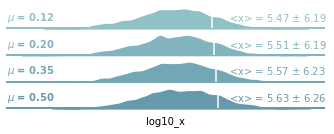

In [12]:
mask = np.logical_and(my_abund_df.dataset == 'schmidt_2016',
                      my_abund_df.condition.str.startswith('chemo'))
plt_dists(my_abund_df[mask])
plt.savefig('../output/schmidt2016_dists.png', dpi=600, facecolor='w')

/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


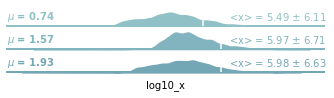

In [13]:
mask = my_abund_df.dataset == 'li_2014'
plt_dists(my_abund_df[mask])
plt.savefig('../output/li2014_dists.png', dpi=600, facecolor='w')

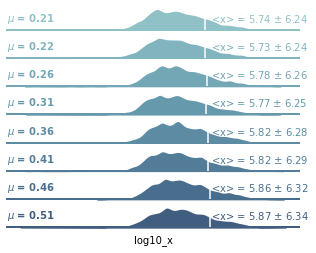

In [14]:
mask = np.logical_and(
    my_abund_df.dataset == 'peebo_2015',
    my_abund_df.condition == 'glucose_minimal')
plt_dists(my_abund_df[mask])
plt.savefig('../output/peebo2015_glucose_dists.png', dpi=600, facecolor='w')

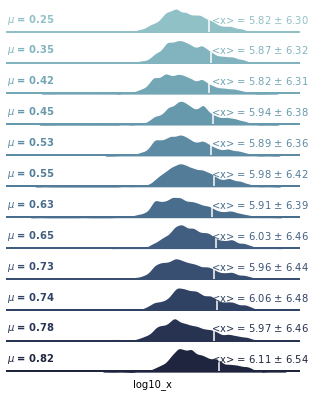

In [15]:
mask = np.logical_and(
    my_abund_df.dataset == 'peebo_2015',
    my_abund_df.condition == 'rich')
plt_dists(my_abund_df[mask])
plt.savefig('../output/peebo2015_rich_media_dists.png', dpi=600, facecolor='w')

In [16]:
group_cols = 'dataset,strain,growth_rate_hr,condition'.split(',')
sort_by = 'tot_per_cell'

In [17]:
# PCA on log-scaled data - want to explain large changes
mask = np.logical_and(my_abund_df.dataset == 'schmidt_2016',
                      my_abund_df.condition.str.startswith('chemo'))
subset_df = my_abund_df[mask]
pivoted_df = subset_df.pivot(columns=group_cols).log10_x
non_null = np.logical_and(pivoted_df.notnull().all(axis=1), 
                          (pivoted_df != 0).all(axis=1))
non_null = np.logical_and(non_null, 
                          np.isfinite(pivoted_df).all(axis=1))
non_null_df = pivoted_df[non_null]
display(non_null_df)

# PCA data are samples on rows, features on columns
X = non_null_df.values.T
display(X)

# Standard scaler does a Z-transform
scaler = StandardScaler()
X_normed = scaler.fit_transform(X)
display(X_normed)

spc = SparsePCA(n_components=2, ridge_alpha=0.5)
transformed_data = spc.fit_transform(X_normed)

dataset           schmidt_2016                                              
strain                 BW25113                                              
growth_rate_hr            0.12           0.20            0.35           0.50
condition      chemostat_u0.12 chemostat_u0.2 chemostat_u0.35 chemostat_u0.5
b_number                                                                    
b0002                 5.919757       6.057605        6.259900       6.652942
b0003                 4.446950       4.506182        4.576509       4.781536
b0004                 6.003155       6.054297        6.224725       6.469159
b0006                 4.603915       4.796558        4.895418       5.005121
b0008                 5.994383       6.098608        6.250163       6.415247
...                        ...            ...             ...            ...
b4517                 4.262494       4.490783        4.398695       4.678304
b4537                 3.887626       4.151229        4.275142       4.473900
b4546                 3.118683       3.325259        3.368793       3.507669
b4554                 4.338699       4.271506        4.177412       4.310371
b4558                 4.918895       4.948405        5.036147       5.109993

[1959 rows x 4 columns]

array([[5.91975722, 4.4469502 , 6.00315548, ..., 3.11868315, 4.33869869,
        4.91889543],
       [6.05760527, 4.50618175, 6.05429661, ..., 3.32525879, 4.27150561,
        4.94840543],
       [6.2598996 , 4.57650875, 6.22472498, ..., 3.36879261, 4.17741216,
        5.03614656],
       [6.65294187, 4.78153564, 6.46915859, ..., 3.50766886, 4.31037107,
        5.10999313]])

array([[-1.09560856, -1.03635082, -1.01492023, ..., -1.51644193,
         1.05393337, -1.12370541],
       [-0.59682845, -0.56720655, -0.73386864, ..., -0.03473081,
        -0.0491045 , -0.73110899],
       [ 0.13513969, -0.01018054,  0.20273884, ...,  0.27752552,
        -1.59373764,  0.43618547],
       [ 1.55729732,  1.61373791,  1.54605003, ...,  1.27364722,
         0.58890877,  1.41862893]])

In [18]:
mask = spc.components_[0] != 0
non_null_df.iloc[mask]

dataset           schmidt_2016                                              
strain                 BW25113                                              
growth_rate_hr            0.12           0.20            0.35           0.50
condition      chemostat_u0.12 chemostat_u0.2 chemostat_u0.35 chemostat_u0.5
b_number                                                                    
b0002                 5.919757       6.057605        6.259900       6.652942
b0004                 6.003155       6.054297        6.224725       6.469159
b0006                 4.603915       4.796558        4.895418       5.005121
b0008                 5.994383       6.098608        6.250163       6.415247
b0009                 3.486978       3.576584        3.607784       3.716442
...                        ...            ...             ...            ...
b4485                 3.751449       3.232261        2.929007       2.937550
b4517                 4.262494       4.490783        4.398695       4.678304
b4537                 3.887626       4.151229        4.275142       4.473900
b4546                 3.118683       3.325259        3.368793       3.507669
b4558                 4.918895       4.948405        5.036147       5.109993

[1278 rows x 4 columns]

In [19]:
mask = np.abs(spc.components_[0]) > 0.038
non_null_df.iloc[mask].index
mask2 = raw_abund_df.index.isin(non_null_df.iloc[mask].index)
raw_abund_df[mask2].groupby('gene_name').first()

,condition,go_terms,cog_class,cog_category,cog_letter,growth_rate_hr,gene_product,tot_per_cell,fg_per_cell,dataset,dataset_name,strain
gene_name,,,,,,,,,,,,
aceK,lb_miller,GO:0016788; GO:0005515; GO:0070262; GO:0005829...,cellular processes and signaling,signal transduction mechanisms,T,1.9,isocitrate dehydrogenase kinase/phosphatase,9.918584,0.001115,schmidt_2016,Schmidt et al. 2016,BW25113
ahpF,lb_miller,GO:0005623; GO:0022900; GO:0009321; GO:0050660...,cellular processes and signaling,defense mechanisms,V,1.9,"alkyl hydroperoxide reductase, AhpF component",10237.962827,0.954729,schmidt_2016,Schmidt et al. 2016,BW25113
ansA,lb_miller,GO:0016787; GO:0008152; GO:0006520; GO:0003824...,cellular processes and signaling,"intracellular trafficking, secretion, and vesi...",U,1.9,L-asparaginase 1,1249.741636,0.077023,schmidt_2016,Schmidt et al. 2016,BW25113
aroL,lb_miller,GO:0019632; GO:0000287; GO:0005829; GO:0016310...,metabolism,amino acid transport and metabolism,E,1.9,shikimate kinase 2,706.203210,0.022451,schmidt_2016,Schmidt et al. 2016,BW25113
artI,lb_miller,GO:0034220; GO:0015276; GO:0071705; GO:0016020...,cellular processes and signaling,signal transduction mechanisms,T,1.9,putative ABC transporter periplasmic binding p...,5518.700365,0.246707,schmidt_2016,Schmidt et al. 2016,BW25113
...,...,...,...,...,...,...,...,...,...,...,...,...
yheO,lb_miller,GO:0005829,information storage and processing,transcription,K,1.9,DNA-binding transcriptional regulator YheO,1376.699516,0.061295,schmidt_2016,Schmidt et al. 2016,BW25113
yieP,lb_miller,GO:0005829; GO:0003700; GO:0006355; GO:0003677,information storage and processing,transcription,K,1.9,DNA-binding transcriptional regulator YieP,517.750106,0.022411,schmidt_2016,Schmidt et al. 2016,BW25113
yigA,lb_miller,GO:0005829,poorly characterized,function unknown,S,1.9,DUF484 domain-containing protein YigA,23.804603,0.001056,schmidt_2016,Schmidt et al. 2016,BW25113


In [20]:
princomponents_PCA of all data, normalized in advance of PCA')
#pct_variance_explained = 100*spc.explained_variance_ratio_

#print("PC1 explains %.1f%% of variance" % pct_variance_explained[0])
#print("PC2 explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(spc.components_[0].tolist())
display(complist)
complist = tuple(spc.components_[1].tolist())


SyntaxError: invalid syntax (3646686277.py, line 1)

In [ ]:
abund_df